In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc03s

Data load and region parameters

In [3]:
name = 'HV'

In [4]:
reg = 'HV'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']  
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.0005

In [7]:
model02 = lmfit.Model(bfunc03s)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.15
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 1.5

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

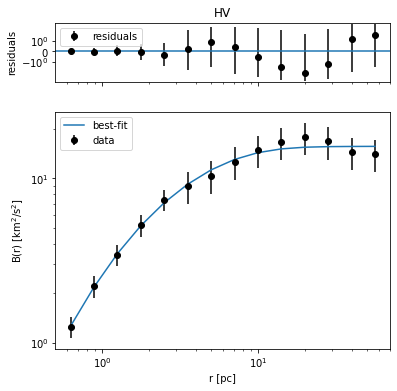

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc03s)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 14
    # variables        = 5
    chi-square         = 1.31141065
    reduced chi-square = 0.14571229
    Akaike info crit   = -23.1513552
    Bayesian info crit = -19.9560686
[[Variables]]
    r0:     2.27416847 +/- 0.96190823 (42.30%) (init = 2.724654)
    sig2:   8.75147326 +/- 2.90825916 (33.23%) (init = 7.864699)
    m:      0.92325602 +/- 0.33497466 (36.28%) (init = 1.5)
    s0:     0.38873038 +/- 0.46948306 (120.77%) (init = 0.9263956)
    noise:  6.1874e-08 +/- 0.55702034 (900250587.46%) (init = 0.005211104)
[[Correlations]] (unreported correlations are < 0.100)
    C(sig2, s0)    =  0.992
    C(r0, s0)      = -0.978
    C(r0, sig2)    = -0.967
    C(sig2, m)     = -0.958
    C(m, s0)       = -0.930
    C(r0, m)       =  0.908
    C(s0, noise)   =  0.867
    C(r0, noise)   = -0.817
    C(sig2, noise) =  0.809
    C(m, noise)    = -0.643


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.024874954955536616 < 1e-05 at iteration 5 and prob(sig2=13.127209893866356) = 0.578689201978968 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=-0.003350051726675325 < 1e-05 at iteration 27 and prob(s0=1.4383024240126014) = 0.9800776167213999 < max(sigmas).
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.68495  -0.67914  -0.67233   2.27417  +0.37453  +0.71308  +1.20509
 sig2 :  -2.04583  -1.39380  -0.82753   8.75147      +inf      +inf      +inf
 m    :  -0.62462  -0.62322  -0.26687   0.92326  +0.18325  +0.38291  +0.67302
 s0   :  -0.31010  -0.27987  -0.15152   0.38873  +0.38767  +0.96859      +inf
 noise:      -inf      -inf      -inf   0.00000      +inf      +inf      +inf


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(noise=5.5686529187859434e-08) = 0.0 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=0.0 < 1e-05 at iteration 1 and prob(noise=6.806131345182819e-08) = 0.0 < max(sigmas).
  warn(errmsg)


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 15.107717990875244 seconds ---
